In [1]:
from datetime import datetime
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns

sns.set_style("white")

ROOT_PATH = Path("..")

In [2]:
# Load Data
_df = pd.read_csv(ROOT_PATH / "data/raw/metadata.csv")
svc_ids = pd.read_json(ROOT_PATH / "data/raw/song_vs_call.json").squeeze()
svc_df = _df.loc[_df.id.isin(svc_ids)].copy()

# Add response variable
type_col = svc_df.type.str.lower().str.replace(" ", "").str.split(",")
svc_df["pred"] = type_col.apply(lambda l: "call" in l).astype(int)

Number of rows: 5800
Percent NaN in svc_df.date: 0.52%


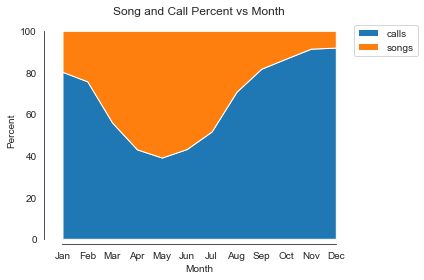

In [3]:
# Build song vs call over time of year heat map
# We go through all of the labels and aggregate them by month, and then plot an area graph that
# will show the break up between the two
svc_df.date = pd.to_datetime(svc_df.date, format="%Y-%m-%d", errors="coerce")
percent_nan = svc_df.date.isnull().sum() * 100 / len(svc_df)
print(f"Number of rows: {len(svc_df)}")
print(f"Percent NaN in svc_df.date: {percent_nan:.2f}%")
call_info = (
    svc_df[["date", "pred"]]
    .groupby(svc_df.date.dt.month)
    .agg({"pred": ["sum", "count"]})
)
call_info.columns = call_info.columns.get_level_values(1)  # drop the top index
call_info["call_pct"] = call_info["sum"] / call_info["count"] * 100
call_info["song_pct"] = 100 - call_info.call_pct
call_info.head()

# Convert integers months to the string rep
x = (
    call_info.index.to_series()
    .apply(lambda m_num: datetime(year=1, month=int(m_num), day=10).strftime("%b"))
    .tolist()
)
y = call_info[["call_pct", "song_pct"]].T.values.tolist()
f, ax = plt.subplots()
ax.grid(False)
ax.stackplot(x, y, labels=["calls", "songs"])
ax.legend(bbox_to_anchor=(1, 1), loc="upper left", ncol=1)
sns.despine(f, ax, offset=5, trim=True)
ax.set_xlabel("Month")
ax.set_ylabel("Percent")
ax.set_title("Song and Call Percent vs Month")
fig_name = "svc_vs_month.png"
f.tight_layout()
f.savefig(f"assets/{fig_name}", dpi=150)

In [33]:
# usa = gpd.read_file("assets/states_21basic/states.shp")
#
# # usa_ax = usa[~usa.STATE_NAME.isin(["Hawaii", "Alaska"])].plot(
# #     color="white", edgecolor="black"
# # )
#
# geo_df = gpd.GeoDataFrame(
#     svc_df, geometry=gpd.points_from_xy(svc_df.lng, svc_df.lat)
# ).dropna(subset=["lng", "lat"])
# # ax = usa.plot()
# # geo_df.plot(ax=usa_ax)
#
# usa.head()
# mdf = gpd.sjoin(geo_df, usa, how="right", op="within")
# mdf.head()
# # mdf["state_geo"] = mdf.STATE_NAME.apply(lambda sn: usa.loc[usa.STATE_NAME==sn, "geometry"])
# # usa.loc[usa.STATE_NAME=="Alaska", "geometry"]
#
# # fig = px.choropleth(
# #     mdf,
# #     geojson=mdf.geometry,
# #     locations=mdf.STATE_NAME,
# #     # locationmode="USA-states",
# #     color="pred",
# #     # scope="usa"
# # )
# # fig.update_geos(fitbounds="locations", visible=False)
# # fig.show()